<img src="./logos/IGFAETalentQ.png" align=left width='400px'/>
<br>


$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\mathbb H}} $


# Algoritmo de Grover

 
Juan Santos Suárez
   
juansantos.suarez@usc.es

# Introducción

Un tipo de problema computacional muy común es la búsqueda de información. Supongamos que tenemos una base de datos estructurada de $N$ elementos, como la siguiente, que está ordenada en orden alfabético.

| Nombre  | Número |
| ---     | ---    | 
| Balbina | 31     |
| Carmen  | 27     |
| Ernesto | 42     |
| Noel    | 113    |
| Omar    | 6      |

Si queremos buscar qué numero tiene Carmen, podemos aprovechar el orden para encontrar su entrada de forma rápida, en particular, en $\mathcal{O}\left(\log\left(N\right)\right)$ consultas.

Sin embargo, si queremos buscar quién tiene un número concreto como el $113$ en la lista anterior, lo mejor que podemos hacer clásicamente es consultar elementos de forma aleatoria hasta conseguir encontrar el que buscamos tras, en promedio, $\frac{N}{2}$ consultas ($\mathcal{O}\left(N\right)$).

En computación cuántica es posible aprovechar la superposición y la interferencia de forma que, utilizando el **algoritmo de Grover**, se encuentre el elemento buscado en $\mathcal{O}\left(\sqrt{N}\right)$ consultas.



Para hacerlo, será necesario codificar de alguna manera la base de datos en un estado cuántico
\begin{equation*}
\ket{s} = \frac{1}{\sqrt{5}} \left(\ket{\text{Balbina}}\ket{31} + \ket{\text{Carmen}}\ket{27} +\ket{\text{Ernesto}}\ket{42} + \ket{\text{Noel}}\ket{113} + \ket{\text{Omar}}\ket{6}\right),
\end{equation*}

y ser capaz de implementar un circuito cuántico $G_\textit{w}$ que aumente significativamente la probabilidad de medir el valor $\textit{w}$ en el registro de búsqueda, es decir,

$$
G_{\textit{w}=113}\ket{s} \approx \ket{\text{Noel}}\ket{113}
$$

# El Algoritmo de Grover

## La “base de datos”

En general, la creación de un estado $\ket{s}$ como el anterior es un problema complicado que no vamos a abordar en esta clase.

Vamos a suponer por simplicidad que nuestra base de datos está formada por todas las cadenas de $n$ bits. Por ejemplo, en el caso de $n=2$, tendremos los elementos $00$, $01$, $10$ y $11$, que en decimal representan los números $0$, $1$, $2$ y $3$. Esto quiere decir que habrá un total de $N=2^n$ elementos.

Codificar esta base de datos en un estado cuántico es muy sencillo, ya que podemos identificar cada elemento $x$ con un estado $\ket{x}$ de la base  computacional (por ejemplo, el elemento $00$ con el estado $\ket{00}$). Así, podremos representar la base de datos con la superposición uniforme.

\begin{equation*}
\ket{s} = H^{\otimes n}\ket{0} = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1} \ket{x}.
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

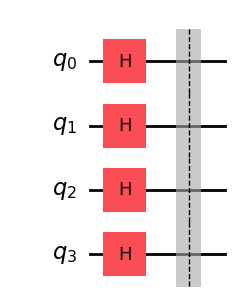

In [2]:
# Creamos nuestra "base de datos"
# Elegimos n
n = 4

# Definimos el circuito con n cúbits y n bits
s_circuit = QuantumCircuit(n)

# Aplicamos puertas H en todos los cúbits
s_circuit.h(range(n))
s_circuit.barrier()

# Dibujamos el circuito
s_circuit.draw('mpl')

## Las soluciones

Consideremos un conjunto $W=\left\{\textit{w}_i\right\}_{i=1}^d$ de $d$ elementos que satisfacen ciertos criterios de búsqueda. Para identificar los elementos de $W$ introducimos una función $f_\textit{w}(x)$ definida como

\begin{equation}
f_\textit{w}(x) = \left\{ \begin{array}{lcc}
             1 &   si  & x \in W \\
              0 &  si & x \not\in W \end{array}
   \right..
\end{equation}

En lenguaje coloquial, $f_\textit{w}$ es la función “reconocer si el registro $x$ está en $W$”. Al igual que cuando buscas una aguja en un pajar, saber cómo es una aguja no te ayuda a encontrarla, sólo a reconocerla si te encuentras con ella. 

Cuánticamente, definimos el estado buscado como un vector unitario compuesto por todos los elementos que son solución,
\begin{equation*}
\ket{\textit{w}}=\frac{1}{\sqrt{d}}\sum_{x \in W}\ket{x}.
\end{equation*}

 Si consideramos $\ket{s^{\prime}} = \frac{1}{\sqrt{N-d}} \sum_{x \notin W} \ket{x}$, es decir, un vector unitario compuesto por todos los elementos que no son solución, podemos reescribir $\ket{s}$ de una forma más conveniente

\begin{equation*}
\ket{s} = \frac{1}{\sqrt{N}}\sum_x \ket{x} = \frac{1}{\sqrt{N}}\left(\sum_{x \in W} \ket{x} + \sum_{x \not\in W} \ket{x} \right) = \sqrt{\frac{d}{N}} \ket{\textit{w}} + \sqrt{\frac{N-d}{N}} \ket{s^\prime}.
\end{equation*}

Esto quiere decir que podemos pensar nuestro estado $\ket{s}$ como un vector caracterizado por el ángulo $\theta = \arcsin \sqrt{\frac{d}{N}}$ en el plano $\left\{\ket{s^\prime}, \ket{\textit{w}}\right\}$, 

\begin{equation*}
\ket{s} = \sin{\theta}\ket{\textit{w}} + \cos{\theta}\ket{s^\prime}.
\end{equation*}

<img src="images/Grover1.png">

La idea del algoritmo de Grover es transformar el estado $\ket{s}$ aumentando su proyección sobre el estado $\ket{\textit{w}}$ o, lo que es lo mismo, encontrar un operador $G$ que efectúe una rotación en este plano.

## El Oráculo

Ahora necesitamos que de alguna manera la información de la función $f_\textit{w}$ afecte a un estado cuántico. La manera de hacer esto es a través de un *oráculo* $U_\textit{w}$ que cambie el signo de la componente asociada a $\ket{\textit{w}}$ y mantenga igual la asociada a $\ket{s^\prime}$.
 
\begin{equation*}
U_{\textit{w}}\ket{x} = \left(-1\right)^{f_\textit{w}(x)}\ket{x}.
\end{equation*}

La acción del oráculo actuando sobre la superposición uniforme $\ket{s}$ es,
\begin{equation*}
U_\textit{w}\ket{s} = -\sqrt{\frac{d}{N}} \ket{\textit{w}} + \sqrt{\frac{N-d}{N}} \ket{s^\prime}
\end{equation*}

Este cambio de signo no tiene análogo clásico y puede parecer inútil ya que no afecta a la distribución de probabilidad medida. Sin embargo, veremos que es crucial.

<img src="images/Grover2.png">

## Reflexión con respecto a un estado

De forma genérica, dado un estado $\ket{\psi} = V\ket{0}$, el operador $U_\psi$ que refleja la componente paralela a $\ket{\psi}$, viene dado por
    
\begin{equation*}
U_{\psi} = \mathbb{1} - 2 \ket{\psi}\bra{\psi} = \mathbb{1} - 2 V\ket{0}\bra{0}V^\dagger = V(\mathbb{1} - 2 \ket{0}\bra{0})V^\dagger=VU_0V^\dagger
\end{equation*}

Podemos comprobarlo viendo que la acción de $U_\psi$ sobre un estado arbitrario $\ket{u} = u_{\|}\ket{\psi} + u_{\perp} \ket{\psi_\perp}$  deja intacta la componente perpendicular $u_{\perp}$ pero <i>invierte</i> la paralela $u_{\|}$

\begin{gather*}
 U_\psi \ket{u} &=& \big( \mathbb{1}- 2 \ket{\psi}\bra{\psi} \big) \big( u_{\|} \ket{\psi} + u_{\perp} \ket{\psi_\perp} \big) \\
\rule{0mm}{6mm} &=& u_\| \big( \ket{\psi} - 2\ket{\psi} \big)  + u_\perp \big( \ket{\psi_\perp}- 0\big) \\
\rule{0mm}{6mm} &=&  - u_\|\ket{\psi} + u_\perp  \ket{\psi_\perp}
 \end{gather*}

donde hemos usado que $\left\langle\psi|\psi_\perp\right\rangle = 0$. Es evidente que $U_{\psi_\perp} = -  U_{\psi} $    

<div class="alert alert-block alert-success">
<b> Ejercicio: </b>    
Comprueba con lápiz y papel que $U_{0} \equiv \mathbb{1} - 2 \ket{0}\bra{0}$ se puede implementar con el circuito
    
<div style="text-align: center;">
    <img src="images/Reflector.png" width="400px"/>
</div>
    
</div>

El resultado de este ejercicio permite construir el oráculo $U_\textit{w}=\prod_i^d U_{\textit{w}_i}$ de manera sencilla en el caso de conocer $\ket{\textit{w}_i}=V_i\ket{0}$. Como cada, $\textit{w}_i$ es una única *bitstring*, es trivial que el operador $V$ consistirá solo en aplicar puertas $X$.


In [4]:
# Definimos la lista de elementos w que queramos
w_list = ['0000', '1111']
d = len(w_list)

<div class="alert alert-block alert-success">
<b> Ejercicio: </b>    Completa el código que implementa el oráculo

</div>

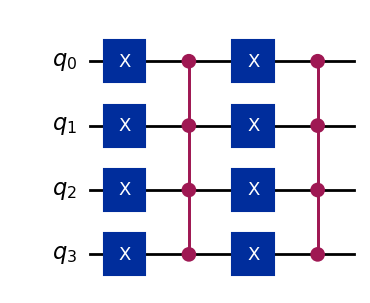

In [6]:
from qiskit.circuit.library import ZGate
# Creamos el oráculo que marque el estado w.
U_w_circuit = QuantumCircuit(n)

# Sólo tenemos que añadir puertas X en los cúbits en los que w valga 0 ya que cuando vale 1 se cancelan.
for k in range(d):
    #### ========================================
    # Escribe tu solución aquí.
    w = w_list[k]
    #### ========================================
    for i in range(n-1, -1, -1): # Recorremos los cúbits de abajo a arriba de acuerdo al convenio que usa Qiskit.
    #### ========================================
    # Escribe tu solución aquí.
        if w[i]=='0':
            U_w_circuit.x(i)
    #### ========================================
    # Ahora tenemos que añadir una puerta controlada Z con todos los cúbits de entrada menos el último.
    # Como esta instrucción no está disponible como método del objeto QuantumCircuit, la añadimos importando la puerta ZGate y llamando
    # al método control de la puerta ZGate con los cúbits de control como argumento.
    U_w_circuit.append(ZGate().control(n-1), range(n))
    # Añadimos de nuevo puertas X
    for i in range(n-1, -1, -1): # Recorremos los cúbits de abajo a arriba de acuerdo al convenio que usa Qiskit.
    #### ========================================
        if w[i]=='0':
            U_w_circuit.x(i)
    #### ========================================
U_w_circuit.draw('mpl')

Veamos que la matriz que representa este circuito sólamente cambia el signo a la componente en $\ket{\textit{w}}$

In [7]:
from qiskit.quantum_info import Operator

Operator(U_w_circuit).draw('latex', max_size=16)

<IPython.core.display.Latex object>

Podemos componer este circuito con el que preparaba $\ket{s}$ para tener $U_\textit{w} \ket{s}$.

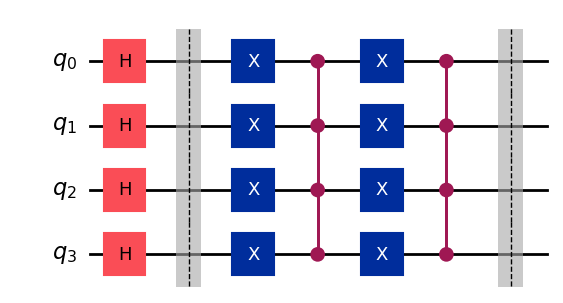

In [8]:
Uw_s_circuit = s_circuit.compose(U_w_circuit)
Uw_s_circuit.barrier()
Uw_s_circuit.draw('mpl')

Y ver que, efectivamente, su acción es la esperada.

In [9]:
from qiskit.quantum_info import Statevector

Statevector(Uw_s_circuit).draw('latex', max_size=16)

<IPython.core.display.Latex object>

<div class="alert alert-block alert-warning">
Nota: Al utilizar las clases <code>Statevector</code> y <code>Operator</code>, estamos simulando clásicamente el circuito, y estamos extrayendo <em>toda</em> la información del sistema cuántico. Evidentemente, la complejidad de esta simulación es exponencial en $n$, por lo que no se podrá hacer para circuitos muy grandes.
</div>


Hasta este punto, a efectos prácticos, hemos sido capaces de “marcar” el estado $\ket{\textit{w}}$. El problema es que este marcaje se ha hecho a través de una fase de la cual no podemos extraer información con medidas.

Es necesario traducir este cambio de fase en una amplificación de la amplitud de probabilidad.

## El Operador de Difusión

Viendo la figura anterior, resulta sencillo ver que aplicando una reflexión en torno al estado inicial $\ket{s}$, tendremos el trabajo hecho. Este operador $D$, conocido como **difusor de Grover** debe de invertir las componentes perpendiculares a $\ket{s}$, es decir,  

$$D = U_{s_{\perp}}=-U_s=-\mathbb{1} + 2 \ket{s}\bra{s} = -H^{\otimes n}\big(\mathbb{1} - 2 \ket{0}\bra{0} \big)H^{\otimes n} = -H^{\otimes n}U_{0}H^{\otimes n}.$$

<div class="alert alert-block alert-info">
Nótese que sabemos escribir como un circuito cuántico el operador $-D=U_s$. Dado que el signo menos es, una fase global, es no físico y podemos considerar $D \sim -D$. En ciertas aplicaciones que no veremos en este curso, este signo puede llegar a ser relevante.

</div>

Podemos ver que, efectivamente, el nuevo estado $-U_sU_\textit{w} \ket{s}$ tiene mayor proyección sobre $\ket{s}$

<img src="images/Grover3.png">

<div class="alert alert-block alert-success">
<b> Ejercicio: </b>    Completa el código que implementa el operador $D$.

</div>

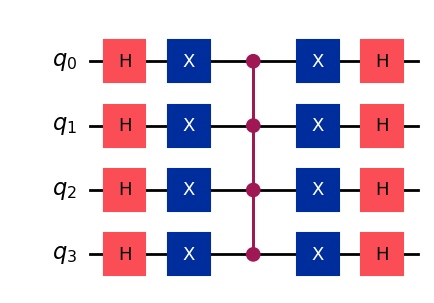

In [20]:
# Creamos el circuito que implementa -D
diffusor_circuit = QuantumCircuit(n)

#### ========================================
# Escribe tu solución aquí.
diffusor_circuit.h(range(n))
diffusor_circuit.x(range(n))
diffusor_circuit.append(ZGate().control(n-1), range(n))
diffusor_circuit.x(range(n))
diffusor_circuit.h(range(n))
#### ========================================

diffusor_circuit.draw('mpl')

In [21]:
Operator(diffusor_circuit).draw('latex', max_size=16)

<IPython.core.display.Latex object>

Componemos el circuito completo

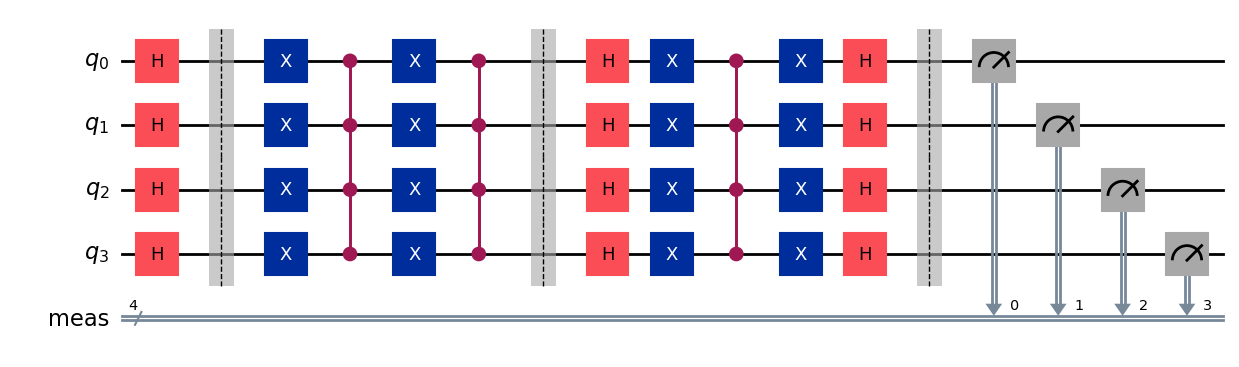

In [22]:
# Componemos el circuito que implementa una iteración de Grover.
grover_circuit = Uw_s_circuit.compose(diffusor_circuit)

# Añadimos medidas en todos los qubits y un registro clásico para almacenar los resultados.
grover_circuit.measure_all()
grover_circuit.draw('mpl')

Qiskit nos permite convertir circuitos a puertas, así que podemos hacerlo de manera más compacta

In [23]:
U_w = U_w_circuit.to_gate()
U_w.name = "$U_w$"
U_s = diffusor_circuit.to_gate()
U_s.name = "$U_s$"

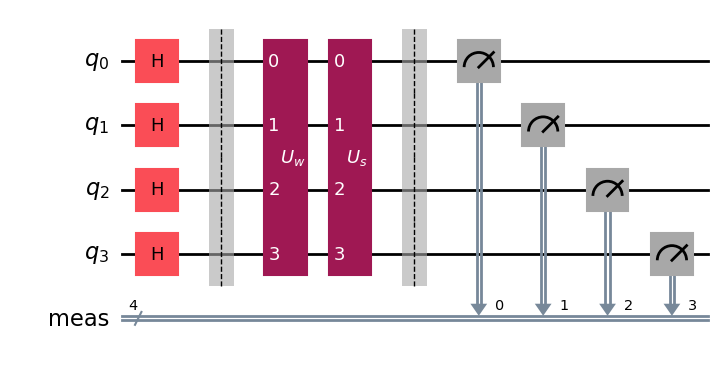

In [24]:
# De forma más compacta
grover_circuit = s_circuit.copy()
grover_circuit.append(U_w, range(n))
grover_circuit.append(U_s, range(n))

# Almacenamos el vector de estado final. Esto hay que hacerlo antes de añadir medidas clásicas.
grover_statevector = Statevector(grover_circuit)

grover_circuit.measure_all()
grover_circuit.draw('mpl')

Podemos simular su resultado para ver que efectivamente el algoritmo funciona como esperamos.

In [25]:
grover_statevector.draw('latex', max_size=16)

<IPython.core.display.Latex object>

O, utilizando medidas

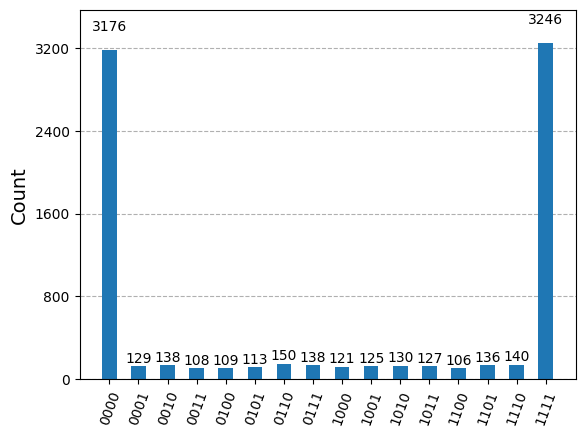

In [26]:
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
# Elegimos cuántas medidas hacer
shots = 8192
# Definimos el Sampler, esto es, la manera de ejecutar el circuito para sacar el contaje al medir cada estado.
# En este caso vamos a utilizar el StatevectorSampler, que simula clásicamente el circuito, pero aquí podríamos por ejemplo llamar a un 
# ordenador cuántico real.
sampler = StatevectorSampler()
job = sampler.run([grover_circuit], shots=shots) # sampler.run([lista_de_circuitos], shots=número_de_shots)
counts = job.result()[0].data.meas.get_counts()  #job.result()[índice_del_circuito].data.nombre_del_registro.get_counts()
# counts es un diccionario formado como {'valor_medido': veces_medido}. Podemos hacer un histograma con la utilidad plot_histogram
plot_histogram(counts)

# Amplificación de Amplitud

Hemos conseguido aumentar la probabilidad de medir el estado buscado. Pero, ¿es suficiente para considerar que el problema está resuelto? ¿Podemos mejorar el resultado?

La clave del negocio consiste en darse cuenta de que el operador $G=-U_sU_\textit{w}$ es en realidad, como se puede ver gráficamente, una rotación de un ángulo $2\theta$.

$$G=\begin{pmatrix}
\cos{2\theta} & \sin{2\theta}\\
-\sin{2\theta} & \cos{2\theta}
\end{pmatrix}.$$

<details>
    <summary><p style="color:blue"> <b>Demostración (hacer click)</b> </p></summary>
    
Por inducción, tras aplicar el operador de Grover $k$ veces, tendremos
    
\begin{align*}
G^k\ket{s} & = &a_k\ket{w} + b_k \ket{s^\prime} \\
&=& -U_sU_w\left(a_{k-1}\ket{w} + b_{k-1} \ket{s^\prime}\right) \\
&=& \left(-\mathbb{1} + 2 \ket{s}\bra{s}\right)\left(-a_{k-1}\ket{w} + b_{k-1}\ket{s^\prime}\right)\\
&=& \left(a_{k-1}\ket{w} - b_{k-1}\ket{s^\prime}\right) + 2\ket{s} \left(-a_{k-1}\left\langle s | w\right\rangle+b_{k-1}\left\langle s | s^\prime \right\rangle\right) \\
&=& a_{k-1}\ket{w} - b_{k-1}\ket{s^\prime} + 2\left(\frac{1}{\sqrt{N}}\ket{w} + \sqrt{\frac{N-1}{N}}\ket{s^\prime}\right) \left(-a_{k-1}\frac{1}{\sqrt{N}}+b_{k-1}\sqrt{\frac{N-1}{N}}\right) \\
&=&\left(a_{k-1} - \frac{2}{N} a_{k-1} + 2\frac{\sqrt{N-1}}{N}\right)\ket{w} + \left(b_{k-1} - 2\frac{\sqrt{N-1}}{N}a_{k-1} + 2\frac{N-1}{N}b_{k-1}\right)\ket{s^\prime}.
\end{align*}
    
Agrupando términos, esta ecuación se puede escribir en forma matricial como

$$
\begin{pmatrix}
a_k\\
b_k
\end{pmatrix}
=
\begin{pmatrix}
\frac{N-2}{N} & 2\frac{\sqrt{N-1}}{N}\\
-2\frac{\sqrt{N-1}}{N} & \frac{N-2}{N}
\end{pmatrix}\begin{pmatrix}
a_{k-1}\\
b_{k-1}
\end{pmatrix}.
$$
    
Es sencillo ver que esta matriz tiene determinante unidad, es decir, ha de ser una matriz de rotación
    
$$\text{det}(G)=\frac{\left(N-2\right)^2}{N^2} + 4\frac{N-1}{N^2} = \frac{N^2 - 4N + 4}{N^2} + \frac{4N-4}{N^2} = 1$$
    
Recordando
    
$$\sin{\theta} = \frac{1}{\sqrt{N}}, \quad \cos{\theta}=\sqrt{\frac{N-1}{N}}$$
$$\frac{N-2}{N}=\cos^2{\theta} - \sin^2{\theta} = \cos{2\theta}$$
$$2\frac{\sqrt{N-1}}{N}=2\sin{\theta}\cos{\theta} = \sin{2\theta}$$
    
se llega a
    
$$G=\begin{pmatrix}
\cos{2\theta} & \sin{2\theta}\\
-\sin{2\theta} & \cos{2\theta}
\end{pmatrix}.$$
</details>



Al identificar $G$ como una matriz de rotación, resulta claro que su acción sobre cualquier estado será rotarlo en el plano $\left\{\ket{\textit{w}}, \ket{s^\prime}\right\}$,

$$G^k\ket{s} = \sin{\left(\left(2k+1\right)\theta\right)}\ket{\textit{w}} + \cos{\left(\left(2k+1\right)\theta\right)}\ket{s^\prime}.$$

Nos interesa saber cuál es el número de veces que hay que aplicar el operador de Grover para maximizar la probabilidad de medir $\ket{\textit{w}}$. Esto es, maximizar la cantidad

$$P_{\textit{w},k}=\sin^2\left[\left(2k+1\right)\theta\right].$$

Si $k$ fuese un número real, es evidente que el resultado sería $k=\frac{\pi}{4\theta}-\frac{1}{2}$. Sin embargo, $k$ es un número entero, así que hay que examinar su parte entera. Se puede demostrar, aunque es un tanto engorroso, que $k=\left[\frac{\pi}{4\theta}\right]$

<div class="alert alert-block alert-success">
<b> Ejercicio: </b>    Comprueba que en el límite $N\gg 1 \Rightarrow \sin\theta \approx \theta$,
    <br>
    
$$ k \approx \frac{\pi}{4}\sqrt{\frac{N}{d}} $$
<br>
</div>


Esto supone un crecimiento $\mathcal{O}(\sqrt{N})$ en lugar de $\mathcal{O}(N)$ que es lo que esperaríamos clásicamente. 

<div class="alert alert-block alert-info">
La manera intuitiva de entender por qué sucede esto es que en el límite $N>>1$, el ángulo $\theta$ se hace pequeño por lo que el crecimiento de la <b>amplitud</b> se vuelve lineal, lo que implica que la probabilidad crezca cuadráticamente. Este truco se conoce como <b> amplificación de amplitud </b>.
    
</div>

Podemos crear un código que implemente $k$ iteraciones de Grover

In [27]:
G_circuit = U_w_circuit.compose(diffusor_circuit)
G = G_circuit.to_gate()
G.name = "$G$"

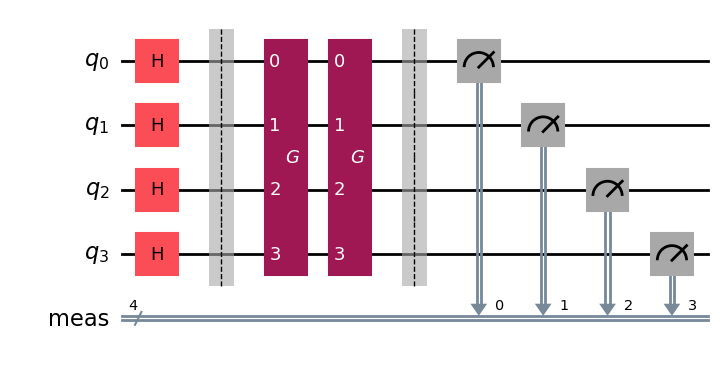

In [28]:
k = 2

grover_circuit = s_circuit.copy()
for _ in range(k):
    grover_circuit.append(G, range(n))
grover_circuit.measure_all()
grover_circuit.draw('mpl')

In [29]:
def run_grover_algorithm(s_circuit, grover_circuit, k, shots=8192):
    """
    Dados el circuito inicial y las puertas que implementan los operadores U_w y U_s,
    Crea y ejecuta el circuito del algoritmo de Grover con k iteraciones
    """
    grover_circuit = s_circuit.copy()
    for _ in range(k):
        grover_circuit.append(G, range(n))
    grover_circuit.measure_all()

    job = sampler.run([grover_circuit], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    prob_w = sum([counts[w] for w in w_list])/shots
    return grover_circuit, counts, prob_w

La probabilidad de medir w es 0.999753


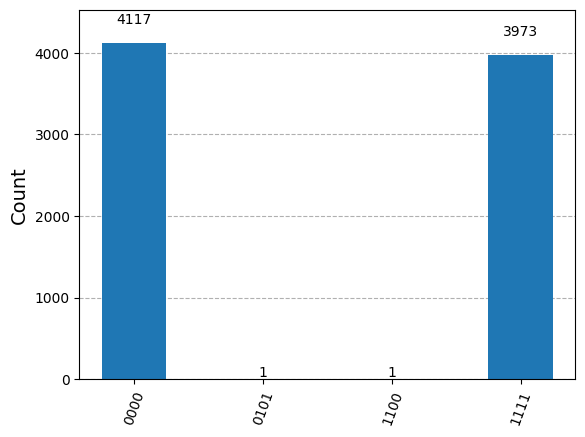

In [37]:
k = 6
grover_circuit, counts, prob_w = run_grover_algorithm(s_circuit, grover_circuit, k, shots=8092)
print(r'La probabilidad de medir w es %f' % (prob_w))
plot_histogram(counts)

<div class="alert alert-block alert-success">
<b>Ejercicio:</b>
    
Comprueba que los resultados numéricos obtenidos al variar $k$ se corresponden con la expresión analítica a la que hemos llegado
    
$$P_{w,k}=\sin^2\left[\left(2k+1\right)\theta\right].$$
    
Para ello, ejecuta la celda anterior para distintos valores de $k$ y anota las probabilidades obtenidas. Después crea una función que calcule el valor analítico de la probabilidad y representa los valores obtenidos para ver que coinciden. Si quieres también puedes hacer un test de $\chi^2$.

In [ ]:
#### ========================================
# Escribe tu solución aquí.
k = np.array([])
probs_numericas = np.array([])
#### ========================================

def prob_fun(k, n):
    #### ========================================
    # Escribe tu solución aquí.

    
    #### ========================================
    return prob

In [ ]:
k_cont = np.linspace(0, 6, 100)

plt.plot(k_cont, prob_fun(k_cont, n), color='teal', label='Valores analíticos en el continuo')
plt.plot(k, probs_numericas, '*', color = 'teal', label='Valores obtenidos numéricamente')
plt.xlabel('$k$')
plt.legend()
plt.ylabel(r'$P_{w,k}$')

# Búsqueda Adaptativa de Grover

Considérese una función de $n$ variables binarias $f : X \rightarrow \mathbb{R}$ con $X=\left\{0, 1\right\}^n$, el algoritmo de Grover permite encontrar el mínimo global $\text{min}_{x\in X}f(x)$.

La idea consiste en dado un valor $y$ utilizar la búsqueda de Grover para amplificar la probabilidad de medir los estados $x$ que satisfagan $f(x)<y$. Tras encontrar un valor $\tilde{x}$ que cumpla esta condición, se redefine $y=f(\tilde{x})$ y se repite el proceso hasta conseguir convergencia.

La manera de hacer esto es definir el estado inicial como
\begin{equation*}
\ket{s}=A_y\ket{0}_n\ket{0}_m=\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\ket{x}_n\ket{f(x)-y}_m
\end{equation*}

Donde tenemos un primer registro de $n$ cúbits que representa los valores $\ket{x}$ y un segundo registro de $m$ cúbits que represente los valores de $\ket{f(x)-y}$.

Dado que el registro de $m$ cúbits tomará valores negativos, lo natural es adoptar una representación en la que uno de los cúbits represente el signo del número y el resto el valor numérico, de forma que con $m$ cúbits representaremos el intervalo $[-2^{m-1}, 2^m-1)$ en lugar de $[0, 2^m)$.

el oráculo sólamente tiene que marcar los estados que tomen valores negativos en el segundo registro
\begin{equation*}
U_\textit{w}=\ket{x}_n\ket{z}_m=\text{sign}(z)\ket{x}_n\ket{z}_m
\end{equation*}


Si bien este operador $U_\textit{w}$ es trivial, la complejidad del problema está en la representación de $A_y$, que depende completamente de la función $f$.

Para funciones arbitrariamente complicadas, la complejidad de implementar $A_y$ podría ser mayor que la de las iteraciones de Grover, con lo que se podría perder la ventaja cuántica.

<img src="./logos/USC + MdM + CIGUS positive.png" align=left width='1000px'/>
<br>